In [139]:
from lxml import etree
import re
import math
import numpy as np
import pandas as pd
from pprint import pprint
from time import time
from sklearn import metrics
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.cluster import DBSCAN
from sklearn.decomposition import TruncatedSVD, PCA, NMF
from sklearn.preprocessing import Normalizer
from sklearn.pipeline import Pipeline
from sklearn.mixture import BayesianGaussianMixture, GaussianMixture
from sklearn.model_selection import GridSearchCV
from sklearn import metrics
from matplotlib import pyplot as plt
import matplotlib.patches as mpatches
from sklearn.cluster import KMeans, MiniBatchKMeans
%matplotlib inline
plt.style.use('ggplot')

In [358]:
class Text(BaseEstimator, TransformerMixin): 
    def __init__(self, lenMin=2000, lenMax=10000, chunks=False, cutoff=None): 
        self.lenMin = lenMin
        self.lenMax = lenMax
        self.chunks=chunks
        self.cutoff=cutoff
        
    def fit(self, *_):
#         print('heyo! fitting')
        return self

    def transform(self, filename): 
#         print('heyo! transforming')
        lenMin, lenMax = self.lenMin, self.lenMax
        self.tree = etree.parse(filename)
        self.allSaidElems = self.tree.findall('.//said[@who]')
        # Only get those in our length range
        self.saidElems = [elem for elem in self.allSaidElems if len(elem.text)>lenMin and len(elem.text)<lenMax]
        self.allChars = [elem.attrib['who'] for elem in self.saidElems]
        self.chars = list(set(self.allChars))
        self.labeledText = [(elem.attrib['who'], elem.text) for elem in self.saidElems]
        self.labeledText = [(item[0], self.clean(item[1])) for item in self.labeledText]
        self.labels = [item[0] for item in self.labeledText]
        charDict = {'Bernard': 0, 'Louis': 1, 'Neville': 2,
                'Rhoda': 3, 'Jinny': 4, 'Susan': 5}
        self.numericLabels = [charDict[label] for label in self.labels]
        self.allText = [item[1] for item in self.labeledText]
        self.charDict = self.makeCharDict()
        self.charChunks, self.charChunksLabels = self.makeCharChunks()
        if self.chunks: 
            self.allText = self.charChunks
            self.labels = self.charChunksLabels
            self.numericLabels = [charDict[label.split('-')[0]] for label in self.labels]
        if self.cutoff is not None: 
            self.allText = [doc[:self.cutoff] for doc in self.allText]
        self.lengths = [len(item) for item in self.allText]
        return self.allText
        
    def makeCharDict(self): 
        """ Make a dictionary of each character's total speech. """
        # Initialize empty dictionary. 
        charDict = {char: "" for char in self.chars}
        for elem in self.allSaidElems: 
            charDict[elem.attrib['who']]+=self.clean(elem.text)
        return charDict
            
    def makeCharChunks(self, n=2): 
        """ Make a list of chunks of character speech. """
        charChunks = []
        charChunksLabels = []
        for char, text in self.charDict.items(): 
            chunks = self.sliceText(text)
            for i, chunk in enumerate(chunks): 
                charChunks.append(chunk)
                charChunksLabels.append(char + '-%s' % i)
        return charChunks, charChunksLabels
        
    def sliceText(self, text, size=8000):
        parts = []
        while len(text) > size: 
            part = text[:size]
            text = text[size:]
            parts.append(part)
        return parts

    def clean(self, utterance): 
        """ 
        Cleans utterances. 
        """
        # Remove "said Bernard," etc. 
        charRegex = "said (%s)" % '|'.join(self.chars)
        out = re.sub(charRegex, '', utterance)
       
        # Remove quotation marks. 
        out = re.sub('[“”"]', '', out)
        
        # Remove line breaks. 
        out = re.sub('\n', ' ', out)
        return out

In [359]:
# Code adapted from http://stackoverflow.com/a/28384887/584121
class DenseTransformer(TransformerMixin):
    
    def __init__(self, *args, **kwargs): 
        return

    def get_params(self, deep=True): 
        """ Dummy method. """
        return {'None': 'None'}
    
    def transform(self, X, y=None, **fit_params):
        return X.todense()

    def fit_transform(self, X, y=None, **fit_params):
        self.fit(X, y, **fit_params)
        return self.transform(X)

    def fit(self, X, y=None, **fit_params):
        return self

In [360]:
def translateNumColor(colorList): 
    colorDict = 'rgbcymk'
    return [colorDict[numColor] for numColor in colorList]    

In [385]:
text = Text(lenMin=4000, lenMax=20000).fit()
docs = text.transform('waves-tei.xml')
labels = text.numericLabels
wordLabels = text.labels
lengths = pd.Series([len(doc) for doc in docs])

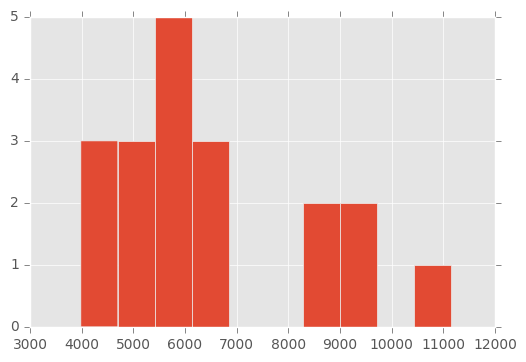

In [386]:
lengths.hist()

In [375]:
len(docs)

16

In [376]:
transformPipeline = Pipeline([    
                         ('tfidf', TfidfVectorizer(max_df=0.3, max_features=500)),
                         ('todense', DenseTransformer()),
                         ('pca', PCA(n_components=5)),
#                          ('gmm', GaussianMixture(n_components=6)),
                        ])

In [377]:
transformed = transformPipeline.fit_transform(docs)
transformed.shape

(16, 5)

In [378]:
ars_history = []
amis_history = []

In [379]:
def bgmIterate(transformed): 
    gmm = GaussianMixture(n_components=6).fit(transformed)
#     bgm = BayesianGaussianMixture(n_components=6).fit(transformed)
    assignments = gmm.predict(transformed)
    ars = metrics.adjusted_rand_score(assignments, labels)
    print(ars)
    ars_history.append(ars)
    amis = metrics.adjusted_mutual_info_score(assignments, labels)
    print(amis)
    amis_history.append(amis)

In [380]:
for i in range(20): 
    bgmIterate(transformed)

0.221556886228
0.260286894955
0.175991861648
0.235863984311
0.281437125749
0.355673592033
0.175991861648
0.233171198175
0.190871369295
0.24448950637
0.142857142857
0.162362033419
0.175991861648
0.235863984311
0.42014242116
0.492940139782
0.175991861648
0.235863984311
0.190871369295
0.24448950637
0.333333333333
0.38042652255
0.333333333333
0.38042652255
0.190871369295
0.24448950637
0.175991861648
0.235863984311
0.175991861648
0.235863984311
0.269841269841
0.288704272957
0.175991861648
0.235863984311
0.190871369295
0.24448950637
0.175991861648
0.235863984311
0.221556886228
0.260286894955


In [381]:
pd.Series(amis_history).describe()

count    20.000000
mean      0.272164
std       0.074543
min       0.162362
25%       0.235864
50%       0.244490
75%       0.267391
max       0.492940
dtype: float64

In [387]:
pd.Series(ars_history).describe()

count    20.000000
mean      0.219774
std       0.071395
min       0.142857
25%       0.175992
50%       0.190871
75%       0.233628
max       0.420142
dtype: float64

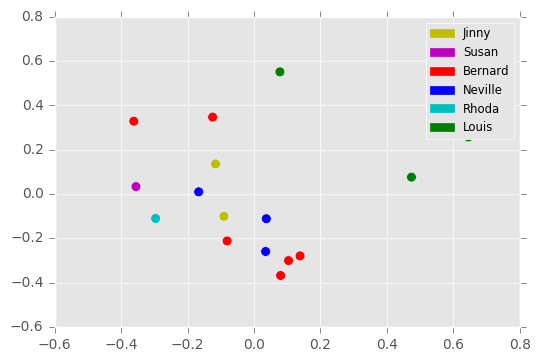

In [383]:
plt.scatter(transformed[:,0], transformed[:,1], 
            c=translateNumColor(labels), s=50)

    # Build legend
colorLabelAssociations = list(set(list(zip(labels, wordLabels, translateNumColor(labels)))))
legends = [mpatches.Patch(color=assoc[2], label=assoc[1])
          for assoc in colorLabelAssociations]
plt.legend(handles=legends, loc='upper right', fontsize='small')

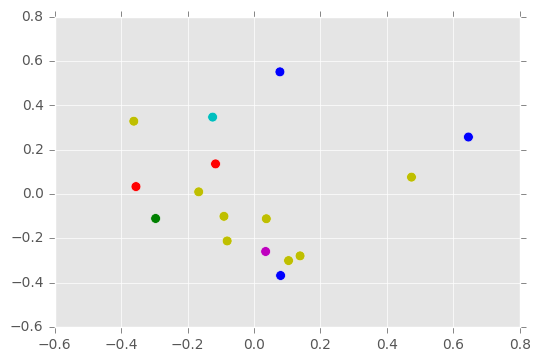

In [384]:
plt.scatter(transformed[:,0], transformed[:,1], 
            c=translateNumColor(assignments), s=50)